In [1]:
%matplotlib inline
#from typing import Dict, Tuple, List, Union, Iterable

import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#from matplotlib.ticker import AutoMinorLocator
plt.style.use("lm")
import numpy as np
#import scipy.linalg as sl #expm
#import os
#import time
#import random
#import string
#import copy
#from tabulate import tabulate
import samplebase as sb

import path_utils as putils

In [20]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

def to_latex_value_with_err(value, err, n_round=1, include_math_env=False):
    assert abs(value) > abs(err)
    val_exp = fexp(value)
    err_2 = err / (10**val_exp)
    n_round = max(-1*fexp(err_2),n_round)
    err_man = round(err_2, n_round)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    err_str = ("{:0." + str(n_round) + "f}").format(err_man)
    if val_exp==0:
        result = val_str + " \pm " + err_str
    else:
        result = r"( " + val_str + " \pm " + err_str + r")\times 10^" + "{" + str(val_exp) +"}"
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

def to_latex_value(value, n_round=1, include_math_env=False):
    val_exp = fexp(value)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    if val_exp==0:
        result = val_str
    else:
        result = val_str + r"\times 10^" + "{" + str(val_exp) +"} "
    
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

print(to_latex_value_with_err(1e-3, 0.5e-6))
print(to_latex_value(4e-3))
print(to_latex_value_with_err(1e-3, 0.5e-6, include_math_env=True))
print(to_latex_value(4e-3, include_math_env=True))
print(to_latex_value(1.3))
print(to_latex_value_with_err(1.2, 1.1))

( 1.0000 \pm 0.0005)\times 10^{-3}
4.0\times 10^{-3} 
$ ( 1.0000 \pm 0.0005)\times 10^{-3} $
$ 4.0\times 10^{-3}  $
1.3
1.2 \pm 1.1


In [2]:
def cluster_along_arg(samples, arg_key, arg_values):
    """
    Transform list of samples into a dictionary that maps 
    from arg_value (described by arg_key) to the clustered 
    samples list.
    """
    clustered_samples = dict()
    for arg_value in arg_values:
        clustered_samples[arg_value] = []
    
    for sample in samples:
        for arg_value in arg_values:
            if sample.args[arg_key] == arg_value:
                clustered_samples[arg_value].append(sample)
    
    return clustered_samples

In [23]:
def plot_overview(plot_functions, n_rows=1, n_cols=3, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.6*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        secondrow = (idx in [7,8,9,10,11,12]) or (idx in [19,20,21,22,23,24]) or (idx in [31,32,33,34,35,36])
        if secondrow:
            plt.gca().set_axis_bgcolor('#ededed')
        pf()
        idx += 1

    plt.subplots_adjust(top=0.96, bottom=0.04, left=0.07, right=0.97, hspace=0.4, wspace=0.35)
    #plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

In [3]:
data_dir = putils.data_dir(6)
data_dir

'/srv/public/workspace/data/rlearn-6'

In [4]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

1689 / 1800


In [5]:
for s in all_samples:
    if s.done:
        scores = np.array(s.result[0]["score"])
        n_scores = len(scores)
        s.result[0]["score_mean"] = np.mean(scores)
        s.result[0]["score_dev"] = np.std(scores)
        s.result[0]["score_err"] = np.std(scores) / np.sqrt(n_scores)

In [6]:
alphas = set()
timesteps = set()
noises = set()
for s in all_samples:
    if s.done:
        alphas.add(s.result[0]["alpha"])
        timesteps.add(s.args["dt"])
        noises.add(s.args["noise"])
alphas = np.fromiter(alphas, dtype=float)
alphas.sort()
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
print(alphas)
print(timesteps)
print(noises)

[1.00000000e-12 1.59985872e-12 2.55954792e-12 4.09491506e-12
 6.55128557e-12 1.04811313e-11 1.67683294e-11 2.68269580e-11
 4.29193426e-11 6.86648845e-11 1.09854114e-10 1.75751062e-10
 2.81176870e-10 4.49843267e-10 7.19685673e-10 1.15139540e-09
 1.84206997e-09 2.94705170e-09 4.71486636e-09 7.54312006e-09
 1.20679264e-08 1.93069773e-08 3.08884360e-08 4.94171336e-08
 7.90604321e-08 1.26485522e-07 2.02358965e-07 3.23745754e-07
 5.17947468e-07 8.28642773e-07 1.32571137e-06 2.12095089e-06
 3.39322177e-06 5.42867544e-06 8.68511374e-06 1.38949549e-05
 2.22299648e-05 3.55648031e-05 5.68986603e-05 9.10298178e-05
 1.45634848e-04 2.32995181e-04 3.72759372e-04 5.96362332e-04
 9.54095476e-04 1.52641797e-03 2.44205309e-03 3.90693994e-03
 6.25055193e-03 1.00000000e-02]
[0.0002  0.00216 0.00412 0.00608 0.00804 0.01   ]
[1.e-12 1.e-10 1.e-08 1.e-06 1.e-04 1.e-02]


In [7]:
samples = cluster_along_arg(all_samples, "noise", noises)
for n in samples.keys():
    samples[n] = cluster_along_arg(samples[n], "dt", timesteps)

In [52]:
plt.rcParams.update({"font.size": 14})
pfs = []
def pf_(alphas ,scores, scores_err, timestep, noise):
    if abs(timestep - 0.00412) < 1e-6 and abs(noise - 1e-8) < 1e-12:
        plt.gca().set_axis_bgcolor('#FFCFC5')
        plt.text(0.5, 0.5,'initial set of parameters\n(roughly)', 
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.errorbar(alphas, - scores, yerr=scores_err, 
                 label=r"$\mathrm{d}t="+to_latex_value(timestep)+r"\quad\sigma="+str(noise)+"$")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")

for n, samples_n in samples.items():
    for dt, samples_n_dt in samples_n.items():
        done_samples = [s for s in samples_n_dt if s.done and s.args["alpha"] < 1e-4]
        sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
        scores = np.array([ s.result[0]["score_mean"] for s in sorted_samples])
        min_indices = np.argmin(-scores)
        scores_err = np.array([ s.result[0]["score_err"] for s in sorted_samples])
        alphas = np.array([ s.args["alpha"] for s in sorted_samples])
        #for x in list(zip(-scores, alphas)):
        #    print(x)
        print("dt {}, noise {}, alpha=argmin(scores)={}".format(dt, n, alphas[min_indices]))
        pfs.append(
            lambda a_=alphas, s_=scores, se_=scores_err, dt_=dt, n_=n: pf_(
                alphas=a_, scores=s_, scores_err=se_, timestep=dt_, noise=n_
            )
        )

dt 0.0002, noise 1e-12, alpha=argmin(scores)=5.179474679231213e-07
dt 0.00216, noise 1e-12, alpha=argmin(scores)=1.5998587196060573e-12
dt 0.0041199999999999995, noise 1e-12, alpha=argmin(scores)=7.906043210907701e-08
dt 0.0060799999999999995, noise 1e-12, alpha=argmin(scores)=3.2374575428176464e-07
dt 0.00804, noise 1e-12, alpha=argmin(scores)=1.5998587196060573e-12
dt 0.01, noise 1e-12, alpha=argmin(scores)=1.151395399326448e-09
dt 0.0002, noise 1e-10, alpha=argmin(scores)=2.2229964825261955e-05
dt 0.00216, noise 1e-10, alpha=argmin(scores)=3.2374575428176464e-07
dt 0.0041199999999999995, noise 1e-10, alpha=argmin(scores)=6.551285568595496e-12
dt 0.0060799999999999995, noise 1e-10, alpha=argmin(scores)=5.179474679231213e-07
dt 0.00804, noise 1e-10, alpha=argmin(scores)=5.179474679231213e-07
dt 0.01, noise 1e-10, alpha=argmin(scores)=2.2229964825261955e-05
dt 0.0002, noise 1e-08, alpha=argmin(scores)=3.088843596477485e-08
dt 0.00216, noise 1e-08, alpha=argmin(scores)=3.237457542817646

In [53]:
len(pfs) / 3

12.0

/srv/public/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':
/srv/public/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  """


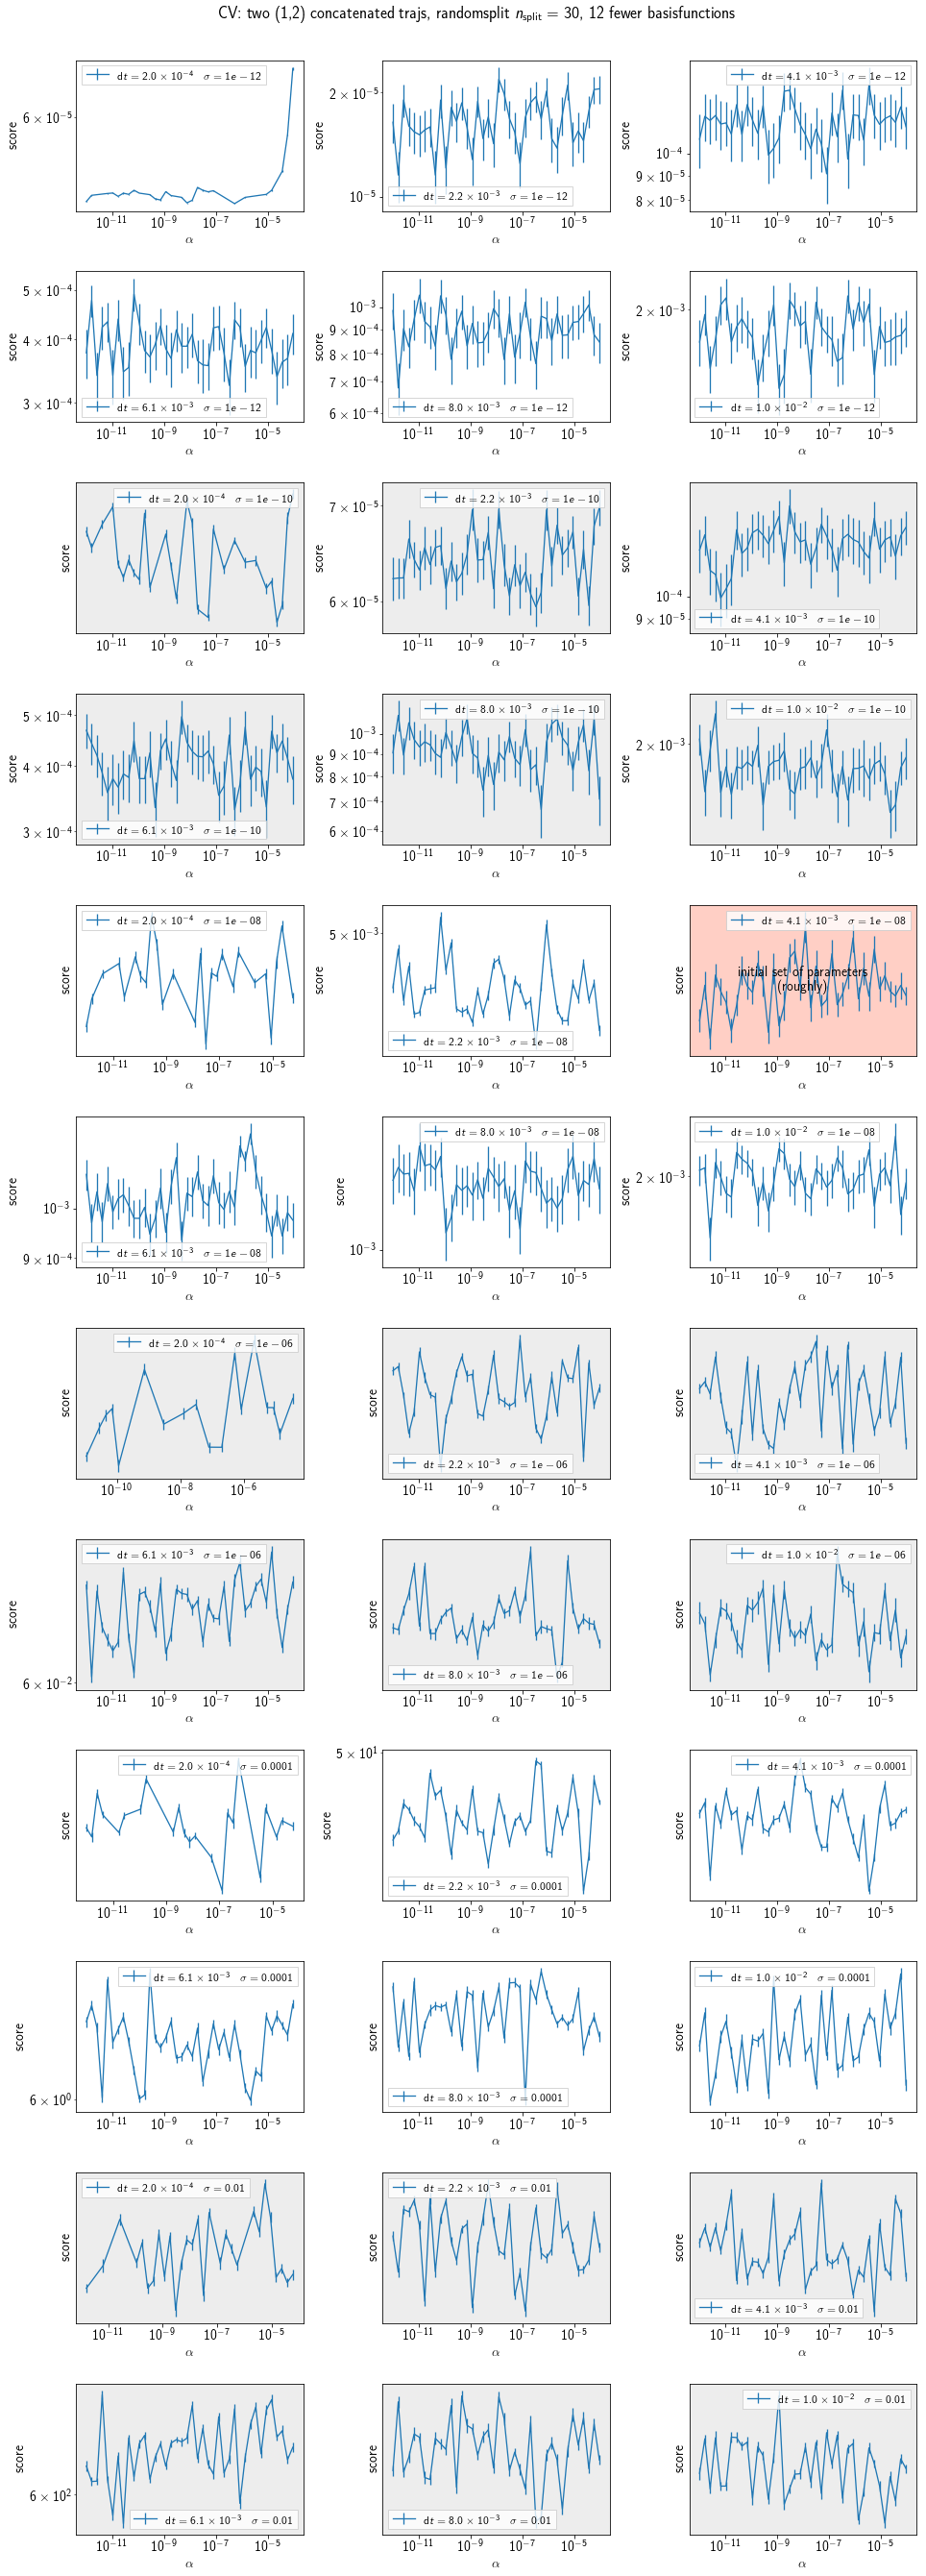

In [54]:
plot_overview(pfs, n_rows=12, n_cols=3, size_factor=0.9)
plt.suptitle("CV: two (1,2) concatenated trajs, randomsplit $n_\mathrm{split}=30$, 12 fewer basisfunctions")
plt.savefig("fewerbfc_sample_dt_n.pdf", bbox_inches="tight", transparent=False)

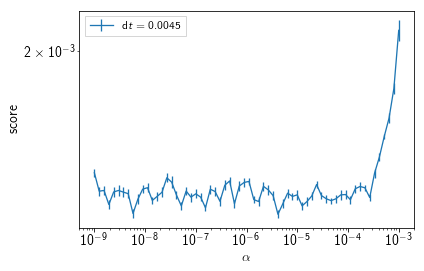

In [35]:
plt.rcParams.update({"font.size": 14})
dt = 0.0045
samples_dt = samples[dt]
sorted_samples = sorted(samples_dt, key=lambda x: x.args["alpha"])
scores = np.array([ s.result[0]["score_mean"] for s in sorted_samples ])
scores_err = np.array([ s.result[0]["score_err"] for s in sorted_samples ])
alphas = np.array([ s.args["alpha"] for s in sorted_samples ])
plt.errorbar(alphas, - scores, yerr=scores_err, label=r"$\mathrm{d}t="+str(dt)+r"$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("score")
#plt.xlim(1e-7, 1e-4)
plt.show()

In [27]:
s = all_samples[0]

In [28]:
s.args

{'alpha': 1.7301957388458942e-08, 'dt': 0.0035, 'n_splits': 30, 'noise': 1e-08}

In [29]:
s.result[0]["score"]

[-0.0020360938009931495,
 -0.001944759029643199,
 -0.0019536981578636655,
 -0.00208116472584667,
 -0.002119211165749518,
 -0.0018875824834619233,
 -0.0020395933055536108,
 -0.0018848193134049463,
 -0.002055387646903003,
 -0.0019649558676171244,
 -0.00195541290384593,
 -0.0019273075041163056,
 -0.0018655261958977194,
 -0.002037971909698172,
 -0.0020492201833354653,
 -0.001898063741700636,
 -0.0019227552681468144,
 -0.0020687739717362924,
 -0.0018647836570158576,
 -0.0018647883919573679,
 -0.0018485270443616268,
 -0.0021230916623861543,
 -0.0020571015415735143,
 -0.0019958294994268087,
 -0.002128498625845928,
 -0.0020929864039197182,
 -0.0021032518212165674,
 -0.0020576653085877137,
 -0.0019020182030008049,
 -0.002043253142395248]